<a href="https://colab.research.google.com/github/10Vaibhav/Hyperspectral-Satellite-Image-Classification-By-Deep-CNNs/blob/main/HyperSpectralClassification_Hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install earthpy

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat
import pandas as pd

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from keras import Input, Model
from tensorflow.keras.layers import Input, Dense, MaxPooling3D, MaxPooling2D, Dropout, Flatten, Conv3D, Conv2D, LeakyReLU, GlobalAveragePooling2D, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time
seed(11)

In [3]:
# Global Variables
test_ratio = 0.3
windowSize = 3

# Required Functions

In [4]:
def splitTrainTestSet(x, y, testRatio, randomState=345):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=testRatio, random_state=randomState, stratify=y)
  return x_train, x_test, y_train, y_test

In [5]:
def padWithZeros(x, margin=2):
    newX = np.zeros((x.shape[0]+2 * margin, x.shape[1]+2 * margin, x.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:x.shape[0] + x_offset, y_offset:x.shape[1] + y_offset, :] = x
    return newX

In [6]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels=True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)

    # Calculate how many patches will be created to better estimate memory needs
    num_patches = X.shape[0] * X.shape[1]

    # Use float32 instead of float64 to reduce memory usage by half
    patchesData = np.zeros((num_patches, windowSize, windowSize, X.shape[2]), dtype=np.float32)
    patchesLabels = np.zeros(num_patches, dtype=np.int32)

    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1

    if removeZeroLabels:
        patchesData = patchesData[patchesLabels > 0, :, :, :]
        patchesLabels = patchesLabels[patchesLabels > 0]
        patchesLabels -= 1

    return patchesData, patchesLabels

# Load Data

In [7]:
#### x data (1096, 715, 102) Hyperspectral satellite (1096*715, 102)
data = loadmat('Pavia.mat')['pavia']

In [8]:
#### y data (labels) ####
gt = loadmat('Pavia_gt.mat')['pavia_gt']

print(f"Data Shape: {data.shape[:-1]}\nnumber of Bands: {data.shape[-1]}")

Data Shape: (1096, 715)
number of Bands: 102


In [9]:
x, y = createImageCubes(data, gt, windowSize=windowSize, removeZeroLabels=True)
x.shape, y.shape

((148152, 3, 3, 102), (148152,))

In [10]:
# (n, w, h, b)
# (n, w, h, b, 1)

In [11]:
x = x.reshape((x.shape[0], windowSize, windowSize, 102, 1))

In [12]:
x.shape

(148152, 3, 3, 102, 1)

In [13]:
y.shape, np.min(y), np.max(y)

((148152,), np.int32(0), np.int32(8))

In [14]:
x_train, x_test, y_train, y_test = splitTrainTestSet(x, y, test_ratio)
x_train, x_val, y_train, y_val = splitTrainTestSet(x_train, y_train, test_ratio)

# Data Visualization

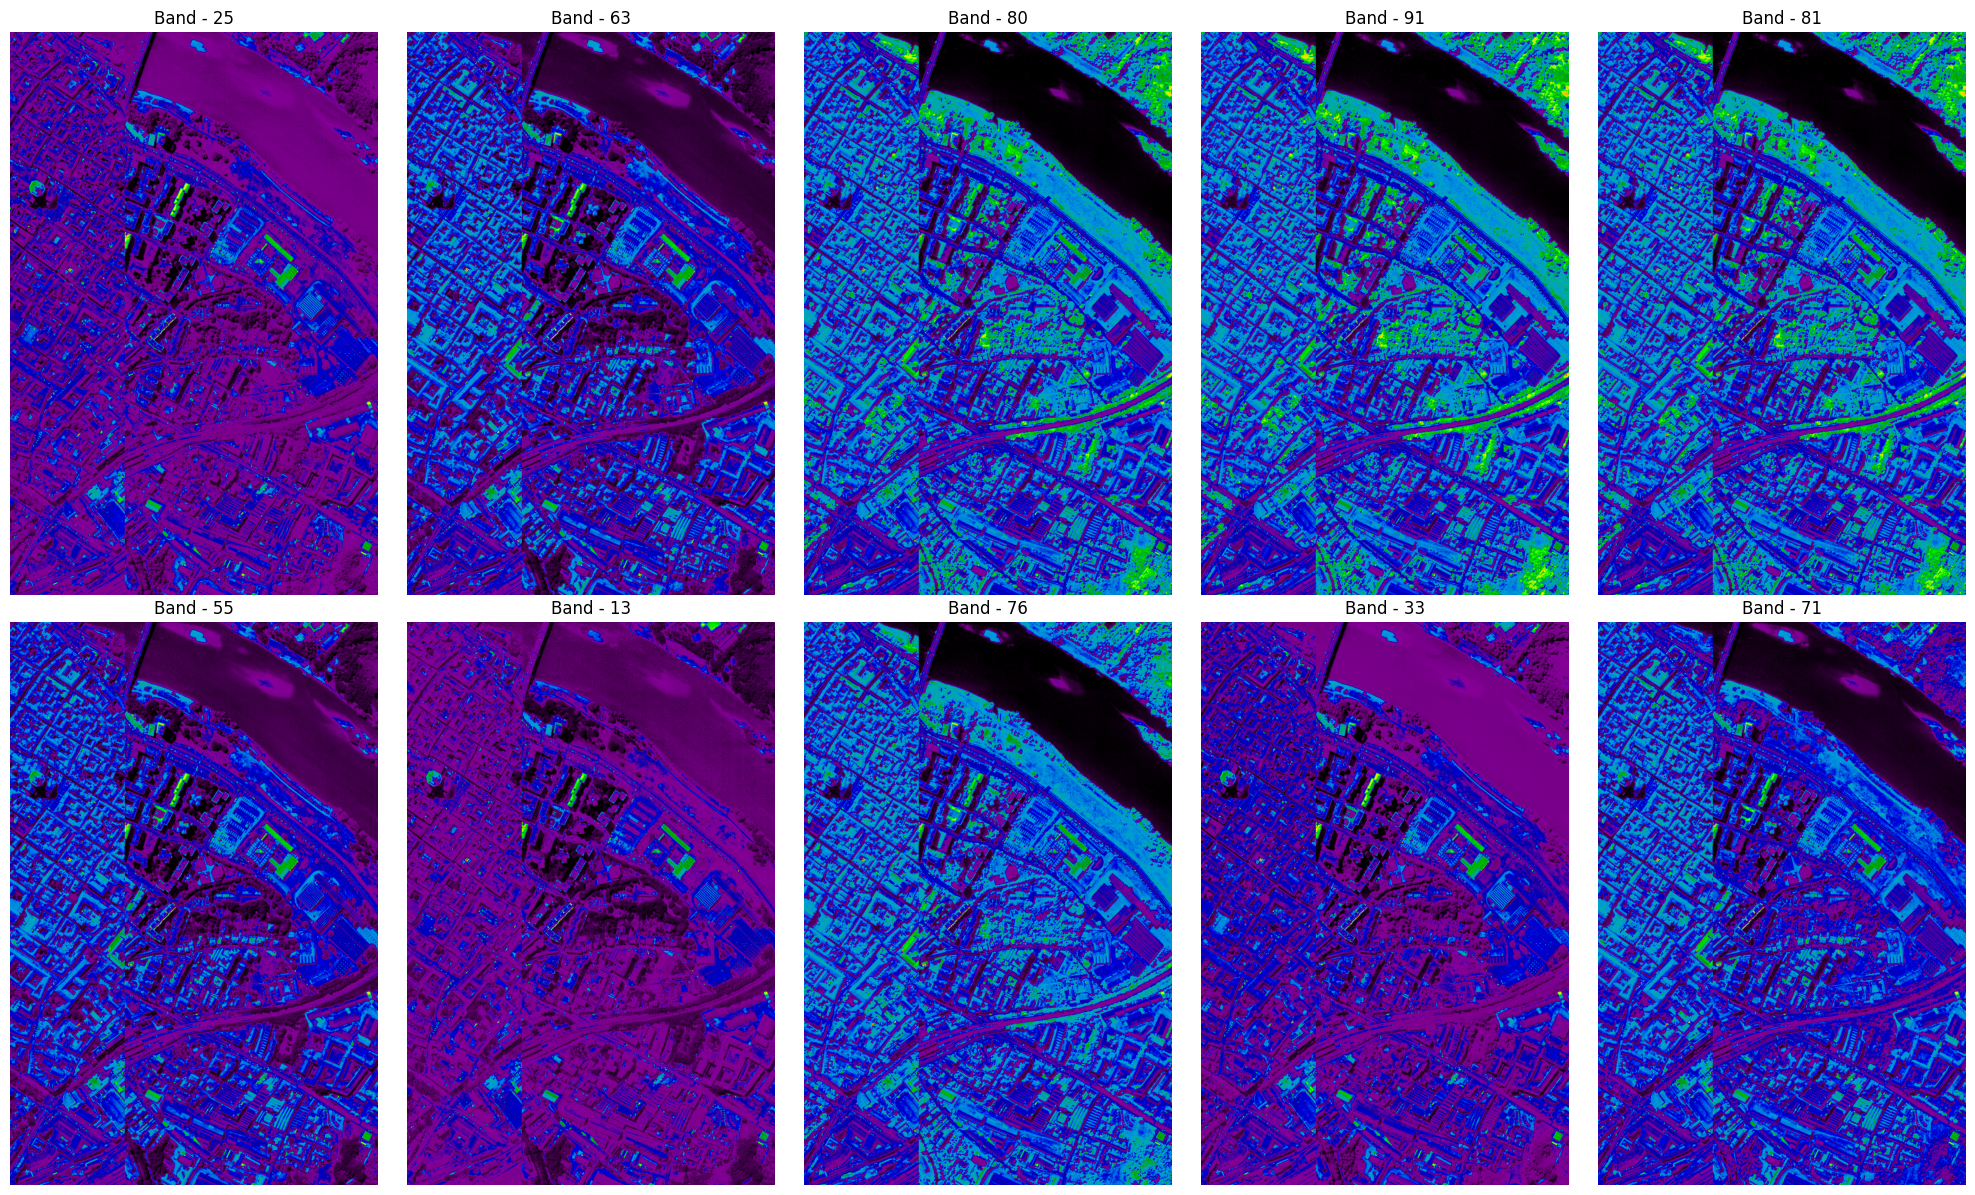

In [15]:
fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2, 5)

for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(data[:,:,c], cmap='nipy_spectral')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c += 1

plt.tight_layout()
plt.show()

# RGB Composite Image

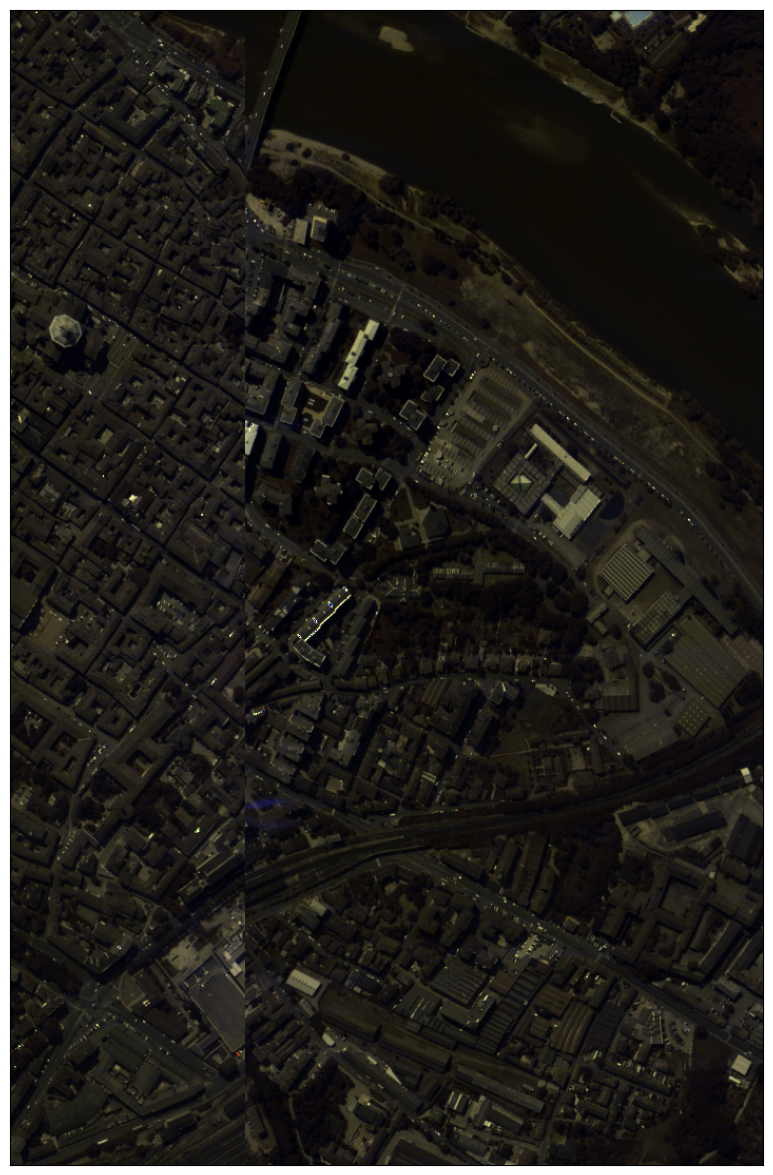

In [16]:
mdata = np.moveaxis(data, -1, 0)

ep.plot_rgb(mdata, (29, 23, 2), figsize=(15, 15))

plt.show()

# Ground Truth Visualization

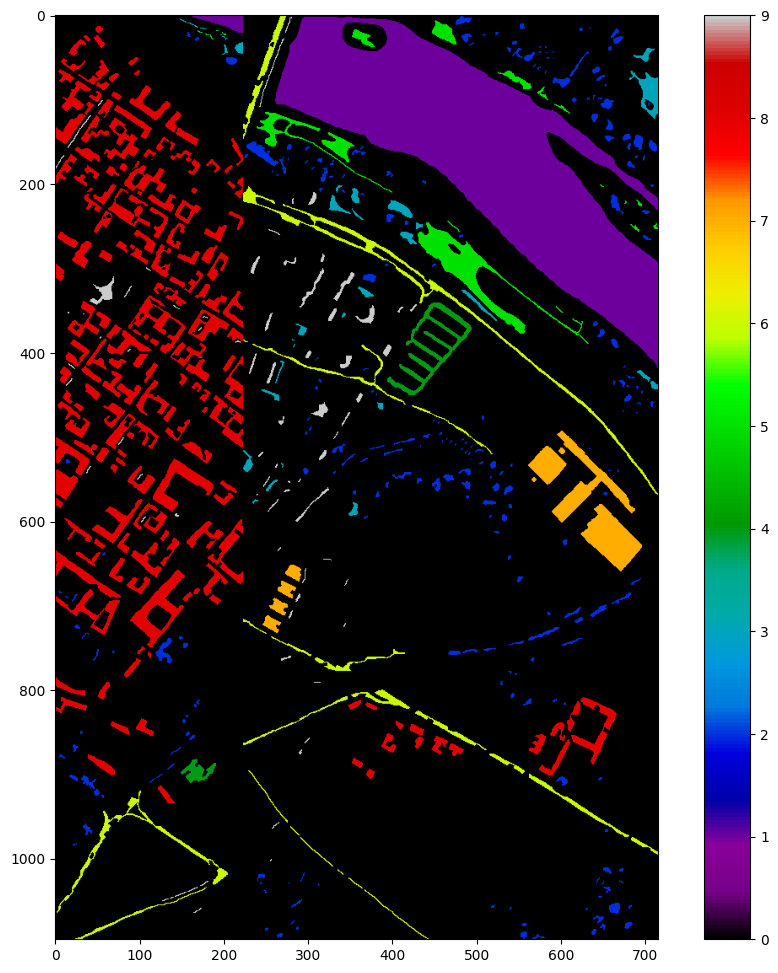

In [17]:
def plot_data(data):
  fig = plt.figure(figsize=(12, 12))
  plt.imshow(data, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('on')
  plt.show()

plot_data(gt)

# Build Model

In [18]:
n_outputs = 9

In [19]:
model = Sequential(name = 'Pavia_3D_CNN')

model.add(Conv3D(16, kernel_size=(2, 2, 2), activation='linear', padding='same', input_shape= (3, 3, 102, 1)))
model.add(LeakyReLU(alpha=0.1))

model.add(Conv3D(32, (3, 3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))

model.add(Conv3D(8, (3, 3, 3), activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding = 'same'))

model.add(Flatten())

model.add(Dense(20, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))

model.add(Dense(n_outputs, activation= 'softmax'))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "Pavia_3D_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 3, 3, 102, 16)  │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 3, 3, 102, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 3, 3, 102, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 3, 3, 102, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 3, 3, 102, 8)   │         6,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 3, 3, 102, 8)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 2, 2, 51, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1632)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │        32,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           189 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,769 (210.04 KB)

 Trainable params: 53,769 (210.04 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
def HybridCNN():
  input_shape = 3, 3, 102, 1

  imIn = Input(shape = input_shape)

  conv_layer1 = Conv3D(filters=16, kernel_size=(1, 1, 7), activation = 'relu', padding='same')(imIn)
  conv_layer2 = Conv3D(filters=32, kernel_size=(3, 3, 5), activation='relu', padding='same')(conv_layer1)
  conv_layer3 = Conv3D(filters=32, kernel_size=(5, 5, 7), activation='relu', padding='same')(conv_layer2)

  conv3d_shape = conv_layer3.shape
  conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3] * conv3d_shape[4]))(conv_layer3)

  conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(conv_layer3)
  conv_layer5 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(conv_layer4)

  conv_layer5 = GlobalAveragePooling2D()(conv_layer5)

  flatten_layer = Flatten()(conv_layer5)

  dense_layer1 = Dense(units=50, activation='relu')(flatten_layer)
  dense_layer1 = Dropout(0.4)(dense_layer1)

  dense_layer2 = Dense(units=20, activation='relu')(dense_layer1)
  dense_layer2 = Dropout(0.4)(dense_layer2)

  output_layer = Dense(units=n_outputs, activation='softmax')(dense_layer2)

  model = Model(inputs=[imIn], outputs = output_layer)

  return model

In [21]:
model2 = HybridCNN()

In [22]:
model2.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3, 3, 102, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 3, 3, 102, 16)  │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 3, 3, 102, 32)  │        23,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 3, 3, 102, 32)  │       179,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 3, 3264)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 3, 3, 64)       │     1,880,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │           189 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,123,947 (8.10 MB)

 Trainable params: 2,123,947 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
102*32

3264

# Model Training

In [24]:
y_train.shape

(72594,)

In [25]:
y_train= tf.keras.utils.to_categorical(y_train)
y_train.shape

(72594, 9)

In [26]:
y_val = tf.keras.utils.to_categorical(y_val)
y_val.shape

(31112, 9)

In [27]:
y_test = tf.keras.utils.to_categorical(y_test)
y_test.shape

(44446, 9)

In [28]:
y_train.shape, y_val.shape, y_test.shape

((72594, 9), (31112, 9), (44446, 9))

In [29]:
x_train.shape, x_val.shape, x_test.shape

((72594, 3, 3, 102, 1), (31112, 3, 3, 102, 1), (44446, 3, 3, 102, 1))

In [30]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [31]:
early_stop = EarlyStopping(monitor= 'val_loss', mode='min', min_delta=0, patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='Pavia_Model3.h5', monitor='val_loss', save_best_only=True)
tensorboard = TensorBoard(log_dir='SA_logs/{}'.format(time()))

In [32]:
hist = model2.fit(x_train, y_train, epochs = 5, batch_size = 512, validation_data=(x_val, y_val), callbacks=[early_stop, checkpoint, tensorboard])

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_79']
Received: inputs=Tensor(shape=(None, 3, 3, 102, 1))
  warnings.warn(msg)


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.4921 - loss: 3.2774

142/142 ━━━━━━━━━━━━━━━━━━━━ 115s 675ms/step - accuracy: 0.4933 - loss: 3.2637 - val_accuracy: 0.9471 - val_loss: 0.1803
Epoch 2/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8550 - loss: 0.3980

142/142 ━━━━━━━━━━━━━━━━━━━━ 100s 502ms/step - accuracy: 0.8551 - loss: 0.3978 - val_accuracy: 0.9618 - val_loss: 0.1028
Epoch 3/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9001 - loss: 0.2695

142/142 ━━━━━━━━━━━━━━━━━━━━ 71s 499ms/step - accuracy: 0.9001 - loss: 0.2694 - val_accuracy: 0.9683 - val_loss: 0.0898
Epoch 4/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9148 - loss: 0.2251

142/142 ━━━━━━━━━━━━━━━━━━━━ 82s 501ms/step - accuracy: 0.9148 - loss: 0.2250 - val_accuracy: 0.9665 - val_loss: 0.0755
Epoch 5/5
142/142 ━━━━━━━━━━━━━━━━━━━━ 83s 506ms/step - accuracy: 0.9140 - loss: 0.2461 - val_accuracy: 0.9546 - val_loss: 0.1002


In [35]:
loss, acc = model2.evaluate(x_test, y_test)

1389/1389 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9660 - loss: 0.0795


In [36]:
print(f"Accuracy: {acc*100}\nloss: {loss}")

Accuracy: 96.71736359596252
loss: 0.0746978148818016


In [37]:
from tensorflow.keras.models import load_model
model = load_model("Pavia_Model3.h5")

In [38]:
pred = np.argmax(model.predict(x_test), axis=1)
#classification Report
print(classification_report(pred, np.argmax(y_test, 1)))

1389/1389 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19792
           1       0.99      0.82      0.90      2777
           2       0.43      0.96      0.60       417
           3       0.00      0.00      0.00         0
           4       1.00      0.80      0.89      2461
           5       0.99      0.87      0.93      3171
           6       0.97      0.99      0.98      2133
           7       1.00      1.00      1.00     12836
           8       1.00      1.00      1.00       859

    accuracy                           0.97     44446
   macro avg       0.82      0.83      0.81     44446
weighted avg       0.99      0.97      0.98     44446



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
pred.shape

(44446,)

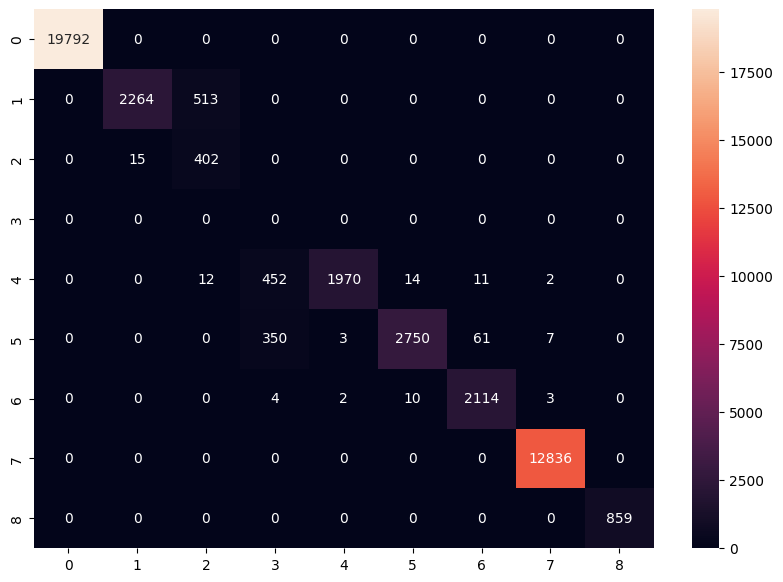

In [40]:
plt.figure(figsize = (10, 7))

mat = confusion_matrix(np.add(pred, 1), np.add(np.argmax(y_test, 1), 1))

df_cm = pd.DataFrame(mat)

sns.heatmap(df_cm, annot=True, fmt = 'd')

plt.show()

# Predicting Whole Image

In [41]:
data.shape

(1096, 715, 102)

In [42]:
model.load_weights('Pavia_Model3.h5')

In [43]:
x11, y11 = createImageCubes(data, gt, windowSize=windowSize, removeZeroLabels=False)


In [44]:
print(f"x11 shape: {x11.shape}")
print(f"x11 dtype: {x11.dtype}")

x11 shape: (783640, 3, 3, 102)
x11 dtype: float32


In [45]:
x11_reshaped = x11.reshape(x11.shape[0], 3, 3, 102, 1)

In [46]:
x11_reshaped.shape

(783640, 3, 3, 102, 1)

In [47]:
prediction = np.argmax(model.predict(x11_reshaped), axis=1)

24489/24489 ━━━━━━━━━━━━━━━━━━━━ 210s 9ms/step


In [48]:
np.min(prediction), np.max(prediction)

(np.int64(0), np.int64(8))

In [49]:
prediction_reshaped = prediction.reshape(1096, 715)


In [50]:
gt = prediction_reshaped

In [51]:
gt.shape

(1096, 715)

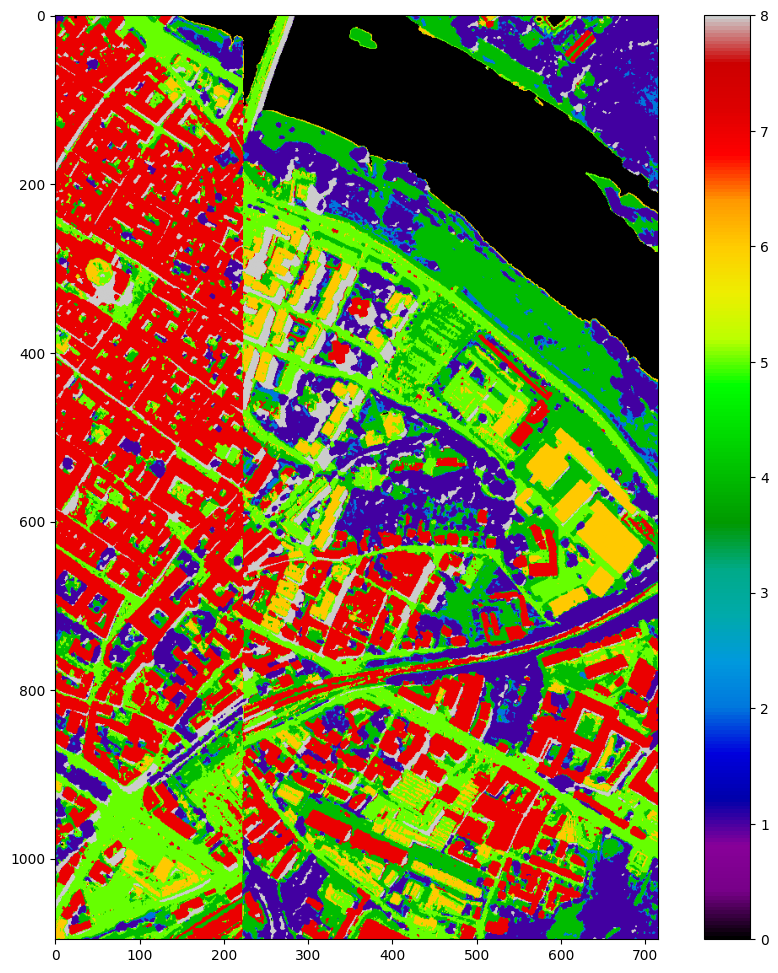

In [52]:
plot_data(prediction_reshaped)